# Time mean heat transport and ASC speed in each regime

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/x77/wf4500/ASC_project/analysis_figs/'

In [2]:
client = Client(memory_limit='900gb',n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 22.92 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37651,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 22.92 TiB
Comm: tcp://127.0.0.1:33333,Total threads: 1
Dashboard: /proxy/42491/status,Memory: 838.19 GiB
Nanny: tcp://127.0.0.1:34159,


2024-10-01 09:24:34,071 - distributed.nanny - WARNING - Restarting worker
2024-10-01 09:24:34,674 - distributed.nanny - WARNING - Restarting worker
2024-10-01 09:24:35,364 - distributed.nanny - WARNING - Restarting worker


In [3]:
# Load the along-slope velocity field
#u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')

# this is the new one:
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho_3deg/Binned_Antarctic_slope_contour_1km_velocities*')

# Load CSHT field
#CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')


In [4]:
# Importing regimes and water mass masks
clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc').regimes_mask
clustering_mask = clustering_mask.rename({'lon':'lon_bin_midpoints'})
CDW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/CDW_mask.nc')['CDW_mask']
DSW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/DSW_mask.nc')['DSW_mask']
AASW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/AASW_mask.nc')['AASW_mask']

In [5]:
#getting correction factor for the CSHT
factor = 1/((CSHT_along.zonal_convergence + CSHT_along.binned_cross_slope_heat_trans)\
.mean('time').sum()/ (CSHT_along.unbinned_heat_transp_across_contour.mean('time').sum()))

In [6]:
# Masking U_along by water mass
u_along_DSW = (u_along.U_along_contour_binned * DSW_mask) * clustering_mask
u_along_CDW = (u_along.U_along_contour_binned * CDW_mask) * clustering_mask
u_along_AASW = (u_along.U_along_contour_binned * AASW_mask) * clustering_mask

# Masking CSHT, binned, without ZC, by water mass
CSHT_DSW = (CSHT_along.binned_cross_slope_heat_trans * factor) * DSW_mask * clustering_mask
CSHT_CDW = (CSHT_along.binned_cross_slope_heat_trans * factor) * CDW_mask * clustering_mask
CSHT_AASW = (CSHT_along.binned_cross_slope_heat_trans * factor) * AASW_mask * clustering_mask


# Masking CSHT, binned, WITH ZC, by water mass
CSHT_ZC_DSW = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence) * factor) * DSW_mask * clustering_mask
CSHT_ZC_CDW = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence) * factor) * CDW_mask * clustering_mask
CSHT_ZC_AASW = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence) * factor) * AASW_mask * clustering_mask

Sanity check.... is the mean CSHT negative/Southward?

In [7]:
((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence) * factor).mean('time').sum().values

array(-1.80163675e+13)

Calculating mean speeds and total CSHTs per water mass

In [8]:
CSHT_ZC_perdensity = (((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence) * factor) * clustering_mask)

In [9]:
#mean ASC speed per water mass layer 
u_along_DSW_mean = u_along_DSW.mean('time').mean(('potrho0','lon_bin_midpoints'))
u_along_CDW_mean = u_along_CDW.mean('time').mean(('potrho0','lon_bin_midpoints'))
u_along_AASW_mean = u_along_AASW.mean('time').mean(('potrho0','lon_bin_midpoints'))

#total CSHT per water mass layer
CSHT_DSW_mean = CSHT_DSW.mean('time').sum(('potrho0','lon_bin_midpoints'))
CSHT_CDW_mean = CSHT_CDW.mean('time').sum(('potrho0','lon_bin_midpoints'))
CSHT_AASW_mean = CSHT_AASW.mean('time').sum(('potrho0','lon_bin_midpoints'))

#total CSHT + zc per water mass layer
CSHT_ZC_DSW_mean = CSHT_ZC_DSW.mean('time').sum(('potrho0','lon_bin_midpoints'))
CSHT_ZC_CDW_mean = CSHT_ZC_CDW.mean('time').sum(('potrho0','lon_bin_midpoints'))
CSHT_ZC_AASW_mean = CSHT_ZC_AASW.mean('time').sum(('potrho0','lon_bin_midpoints'))

In [10]:
%%time
#loading values.
u_along_DSW_mean.load()
u_along_CDW_mean.load()
u_along_AASW_mean.load()
CSHT_DSW_mean.load()
CSHT_CDW_mean.load()
CSHT_AASW_mean.load()
CSHT_ZC_DSW_mean.load()
CSHT_ZC_CDW_mean.load()
CSHT_ZC_AASW_mean.load()

CPU times: user 2min 30s, sys: 13.9 s, total: 2min 44s
Wall time: 4min


<xarray.DataArray (regime: 3)> Size: 24B
array([-1.47808563e+13,  3.02429694e+12, -5.65174888e+13])
Coordinates:
  * regime   (regime) <U7 84B 'Surface' 'Reverse' 'Deep'

([<matplotlib.axis.YTick at 0x154cfa6e2080>,
 [Text(0, 1, 'DSW'), Text(0, 4, 'CDW'), Text(0, 7, 'AASW')])

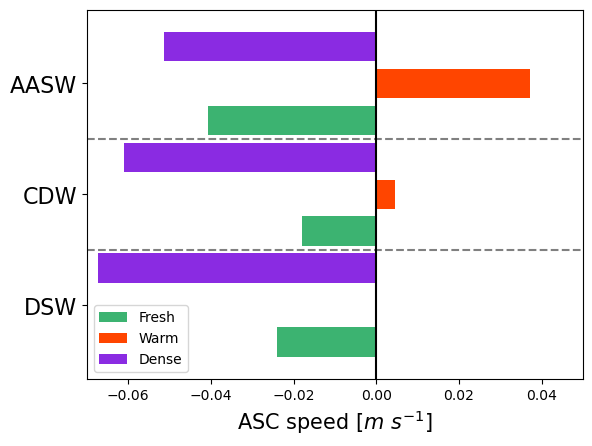

In [11]:
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),u_along_AASW_mean,color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),u_along_CDW_mean,color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),u_along_DSW_mean,color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-.07,.05],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-.07,.05],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-.07,.05]); plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'ASC speed [$m\ s^{-1}$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)

Values are somewhat different in tehre... perhaps we need to do a weigthed mean!

([<matplotlib.axis.YTick at 0x154cf8c442b0>,
 [Text(0, 1, 'DSW'), Text(0, 4, 'CDW'), Text(0, 7, 'AASW')])

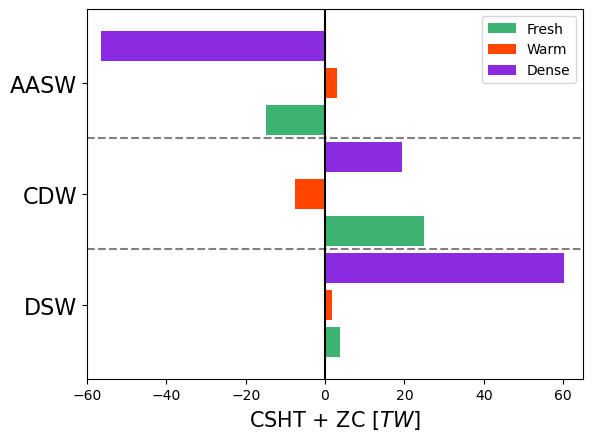

In [12]:
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),CSHT_ZC_AASW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),CSHT_ZC_CDW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),CSHT_ZC_DSW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-60,100],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-60,100],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-60,65]);plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'CSHT + ZC [$TW$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)

([<matplotlib.axis.YTick at 0x154cfffea6b0>,
 [Text(0, 1, 'DSW'), Text(0, 4, 'CDW'), Text(0, 7, 'AASW')])

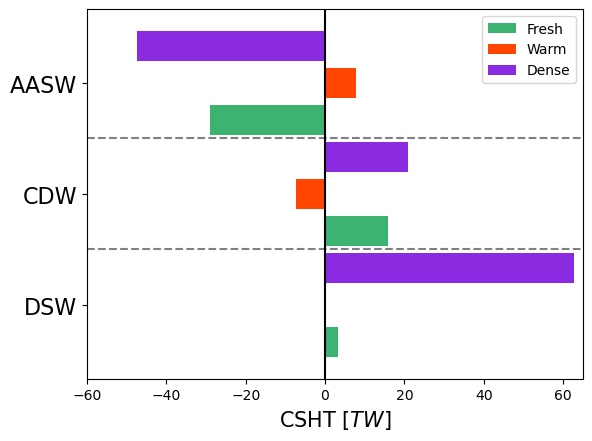

In [13]:
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),CSHT_AASW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),CSHT_CDW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),CSHT_DSW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-60,100],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-60,100],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-60,65]);plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'CSHT [$TW$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)

3-panels heat transport by water mass layer

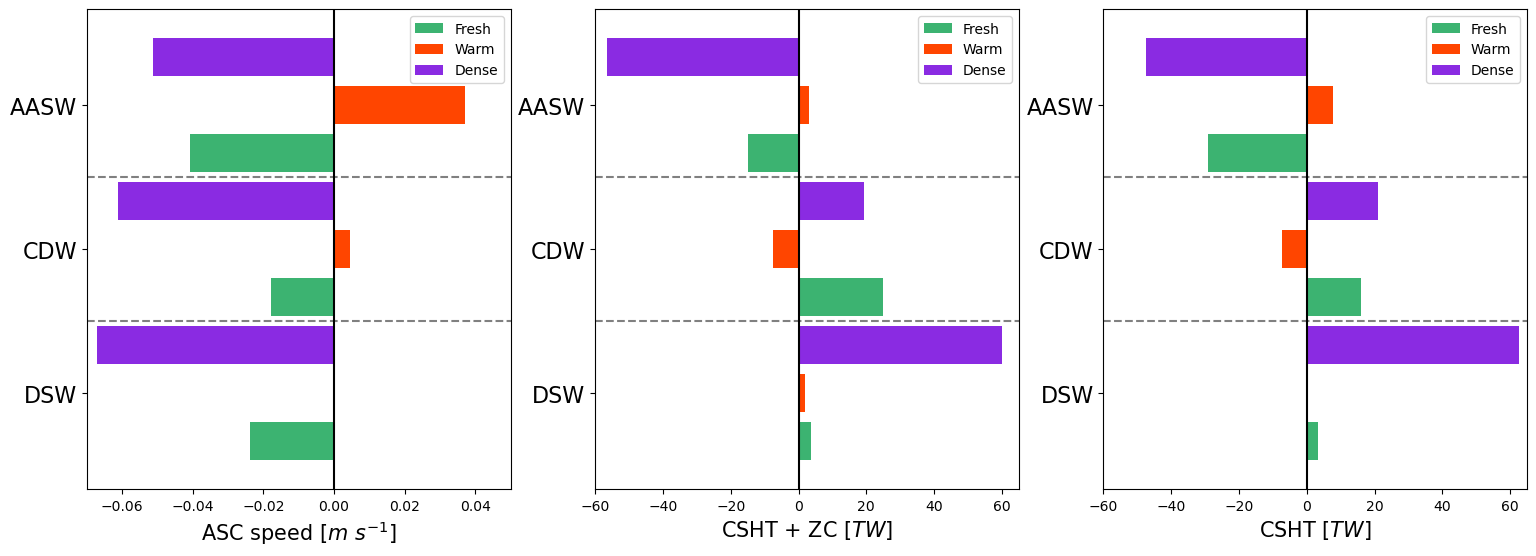

In [14]:
figure = plt.figure(num = 1, figsize = (18, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.6)

plt.subplot(1,3,1) #Bar plots with mean ASC speed
plt.barh(np.arange(6,9),u_along_AASW_mean,color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),u_along_CDW_mean,color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),u_along_DSW_mean,color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-.07,.05],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-.07,.05],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-.07,.05]); plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'ASC speed [$m\ s^{-1}$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)



plt.subplot(1,3,2) #Bar plots CSHT + ZC
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),CSHT_ZC_AASW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),CSHT_ZC_CDW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),CSHT_ZC_DSW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-60,100],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-60,100],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-60,65]);plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'CSHT + ZC [$TW$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)



plt.subplot(1,3,3) #Bar plots CSHT
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),CSHT_AASW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),CSHT_CDW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),CSHT_DSW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-60,100],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-60,100],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
plt.xlim([-60,65]);plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'CSHT [$TW$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)
plt.savefig(figdir +'mean_ASC_CSHT_per_WM.png',dpi=300)

With a variable density definition, the total heat transport of CDW gets positive, except in the reverse regime. Which is sort of contradictive. It would be useful to see how the CDW layer looks like when tagged along the density curtain

### Plot density along contour to see where these watermasses are:

In [15]:
# first get contour information:
# Only need contour on t-grid, because rho is on t-grid (note these won't be the exact same points as where the CSHT is, 
#     as they are on the faces of the t-cells, but I think for this visual purpose it is sufficient.

### NOTE: Just remembered that I think this is a differently defined contour compared with what we used for the CSHT calculation!

# database for control simulation:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'

outfile = '/g/data/g40/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz'
data = np.load(outfile)
contour_mask_numbered = data['contour_mask_numbered']
ylength = contour_mask_numbered.shape[0]
yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1).isel(yt_ocean=slice(0,ylength))
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
contour_mask_numbered = xr.DataArray(contour_mask_numbered).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
num_points = int(contour_mask_numbered.max())  

# stack contour data into 1d:
contour_mask_numbered_1d = contour_mask_numbered.stack(contour_index = ['yt_ocean', 'xt_ocean'])
contour_mask_numbered_1d = contour_mask_numbered_1d.where(contour_mask_numbered_1d > 0, drop = True)

contour_ordering = contour_mask_numbered_1d.copy()
contour_ordering = contour_ordering.sortby(contour_ordering)
#contour_index_array = np.arange(1, len(contour_ordering)+1)

lat_along_contour = contour_ordering.yt_ocean
lon_along_contour = contour_ordering.xt_ocean

In [16]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
potrho_transect = cc.querying.getvar(iaf_cycle3,'pot_rho_0' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength)).mean('time')

# first stack into 1d:
potrho_transect = potrho_transect.stack(contour_index = ['yt_ocean', 'xt_ocean'])

# then select out only points on contour:
potrho_transect = potrho_transect.where(contour_mask_numbered_1d>0, drop = True)

# sort:
potrho_transect = potrho_transect.sortby(contour_ordering).load()

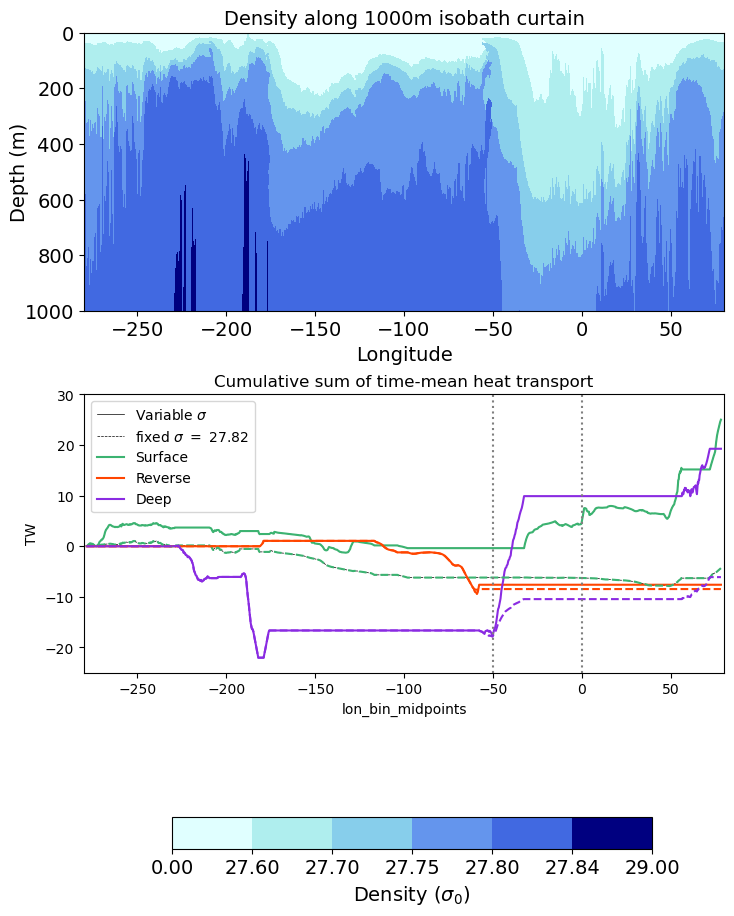

In [17]:
# do contourf with same levels as chosen density levels for CSHT analysis:
fontsize=14

fig = plt.figure(num = 1, figsize = (8, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)

plt.subplot(2,1,1) 

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc = plt.contourf(lon_along_contour, potrho_transect.st_ocean, potrho_transect-1000,levels=levels,colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy'])
plt.ylim(1000,0)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize,labelpad=-3)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title('Density along 1000m isobath curtain',fontsize=fontsize)

cax = fig.add_axes([.21,-.12,.6,.04])
cbar = plt.colorbar(pc, cax=cax,orientation='horizontal')
cbar.set_label(r'Density ($\sigma_0$)',fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(2,1,2)
(CSHT_ZC_CDW.mean('time').sum('potrho0').isel(regime=0).cumsum()/1e12).plot(label=r'Variable $\sigma$',linewidth=.5,color='black')
(CSHT_ZC_perdensity.isel(potrho0=4).mean('time').isel(regime=0).cumsum()/1e12).plot(linestyle='--',label=r'fixed $\sigma\ =\ 27.82$',linewidth=.5,color='black')
(CSHT_ZC_CDW.mean('time').sum('potrho0').isel(regime=0).cumsum()/1e12).plot(label='Surface',color='mediumseagreen')
(CSHT_ZC_CDW.mean('time').sum('potrho0').isel(regime=1).cumsum()/1e12).plot(label='Reverse',color='orangered')
(CSHT_ZC_CDW.mean('time').sum('potrho0').isel(regime=2).cumsum()/1e12).plot(label='Deep',color='blueviolet')
(CSHT_ZC_perdensity.isel(potrho0=4).mean('time').isel(regime=0).cumsum()/1e12).plot(linestyle='--',color='mediumseagreen')
(CSHT_ZC_perdensity.isel(potrho0=4).mean('time').isel(regime=1).cumsum()/1e12).plot(linestyle='--',color='orangered')
(CSHT_ZC_perdensity.isel(potrho0=4).mean('time').isel(regime=2).cumsum()/1e12).plot(linestyle='--',color='blueviolet')

plt.plot([-50,-50],[-25,30],linestyle=':',color='grey')
plt.plot([0,0],[-25,30],linestyle=':',color='grey')
plt.xlim(-280,80);plt.ylim(-25,30)
plt.title('Cumulative sum of time-mean heat transport')
plt.ylabel('TW')
plt.legend()

How does those northward CSHT lok like when binning the CSHT into 10deg larger bins

In [18]:
#10deg amsk
#mask_10deg = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/regime_mask_10degBins.nc')

#importing binned CSHT into thin density slices
CSHT_along_10deg  = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_potrho0_10degBins.nc')
CSHTZC_along_10deg  = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc')

#importing binned CSHT into thin density slices WM
CSHTZC_along_10degWM = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_WMbins_10degBins.nc')


How does the heat transport looks like when using fixed density layers?

We will use the maximum value as the point of intersecion between psoitive and negative transport...

In [19]:
#the loop below will have to be reproduced every time in the model

rhomax=np.zeros([36,])*np.nan
valmax=np.zeros([36,])*np.nan
# extracts the density bin with the maximum sumulative heat transport, i.e., the peak of the curve

for nbin in np.arange(0,36):
    rhomax_ind = CSHTZC_along_10deg.CSHT_ZC_lon_binned.reindex(potrho0=list(reversed(CSHTZC_along_10deg.potrho0)))\
    .cumsum('potrho0').reindex(potrho0=list(reversed(CSHTZC_along_10deg.potrho0))).mean('time').isel(lon_bins=nbin).argmax()
    valmax_ind = CSHTZC_along_10deg.CSHT_ZC_lon_binned.reindex(potrho0=list(reversed(CSHTZC_along_10deg.potrho0)))\
    .cumsum('potrho0').reindex(potrho0=list(reversed(CSHTZC_along_10deg.potrho0)))\
    .mean('time').isel(lon_bins=nbin).max()
    
    rhomax[nbin]=CSHTZC_along_10deg.potrho0.reindex(potrho0=list(reversed(CSHTZC_along_10deg.potrho0)))[rhomax_ind]
    valmax[nbin]=valmax_ind
    #if the heat transport is negative in the entirety of the bin, the level chosen will be 27.84:
    if valmax_ind==0:
        rhomax[nbin]=27.84

#Whenever the desity of reversal is bugger thatn 27.84, we will also chose 27.84
CDW_max_dens =  np.where(rhomax<=27.84,rhomax,27.84) #any densiy bigger than 27.84, becomes 27.84

How does that look like?

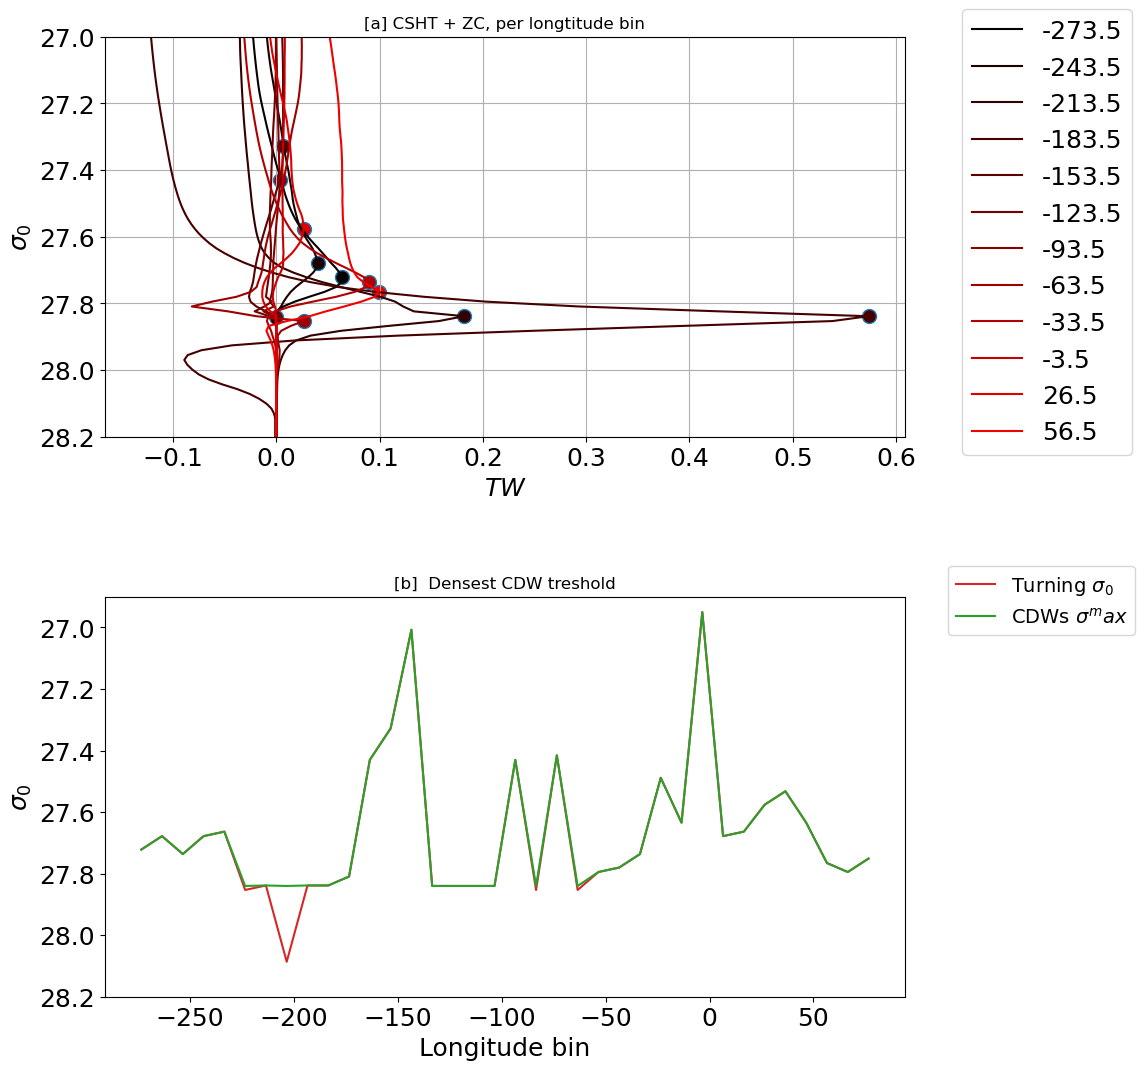

In [20]:
figure = plt.figure(num = 1, figsize = (10, 12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

plt.subplot(2,1,1)
rate_bins=3
for n in np.arange(0,36,rate_bins):
    (CSHTZC_along_10deg.CSHT_ZC_lon_binned.reindex(potrho0=list(reversed(CSHTZC_along_10deg.potrho0)))\
     .cumsum('potrho0').reindex(potrho0=list(reversed(CSHTZC_along_10deg.potrho0)))\
    .mean('time').isel(lon_bins=n)/1e12).plot(y='potrho0',color=[(n+1)/36,0,0],label = str(CSHTZC_along_10deg.lon_bins[n].values))
    plt.scatter(valmax[n]/1e12,rhomax[n],color=[(n+1)/36,0,0],edgecolors='tab:blue',s=100)
plt.ylim(28.2,27); plt.legend(bbox_to_anchor=(1.3, 1.1),fontsize=18)
plt.grid(); plt.xticks(fontsize=18);plt.yticks(fontsize=18); 
plt.xlabel(r'$TW$',fontsize=18); plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.title('[a] CSHT + ZC, per longtitude bin')

plt.subplot(2,1,2)
plt.plot(CSHTZC_along_10deg.lon_bins,rhomax,color='tab:red',label=r'Turning $\sigma_0$')
plt.plot(CSHTZC_along_10deg.lon_bins,CDW_max_dens,color='tab:green',label=r'CDW''s $\sigma^max$')
plt.xticks(fontsize=18);plt.yticks(fontsize=18); 
plt.xlabel('Longitude bin',fontsize=18)
plt.ylabel(r'$\sigma_0$',fontsize=18)
plt.title(r'[b]  Densest CDW treshold') 
plt.legend(bbox_to_anchor=(1.3, 1.1),fontsize=14)
plt.ylim(28.2,26.9);

It seems to me that this approach works quite well in determining the peak of the curve, which is the densest treshold for CDW. Notice that densities might be still super light western Weddell Sea. this will have to be run using daily data...

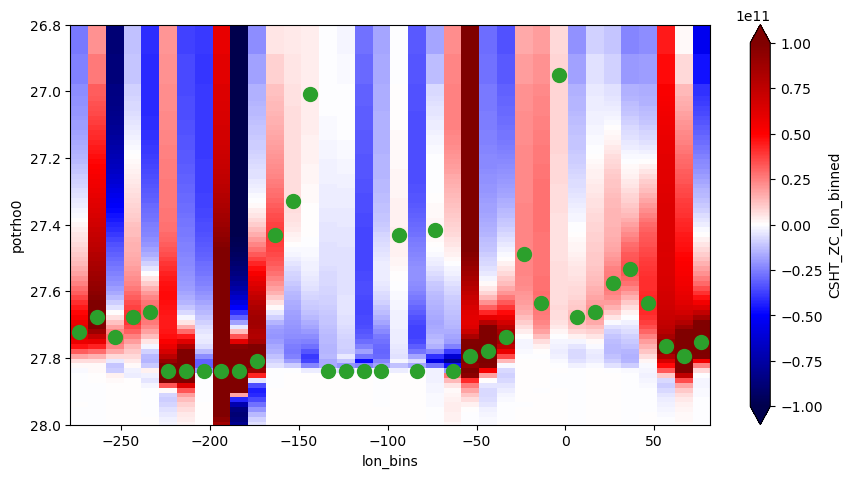

In [21]:
figure = plt.figure(num = 1, figsize = (10, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

CSHTZC_along_10deg.CSHT_ZC_lon_binned.mean('time').reindex(potrho0=list(reversed(CSHTZC_along_10deg.potrho0))).\
cumsum('potrho0').plot(x='lon_bins', vmin=-1e11,vmax=1e11,cmap='seismic')
plt.scatter(CSHTZC_along_10deg.lon_bins,CDW_max_dens,color='tab:green',s=100)
plt.ylim(28,26.8);

In [22]:
lon_bin=10
bin_edges = np.arange(CSHT_along.lon_bin_midpoints[0], CSHT_along.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)


In [23]:
#we need to find within potrho_transect, where is the depth of the target density layer
potrho_transect_lon=potrho_transect.copy()
potrho_transect_lon = potrho_transect_lon.rename({'contour_index':'lon_along_contour'})
potrho_transect_lon['lon_along_contour']=CSHT_along.lon_along_contour.isel(time=0).drop('time')[:-1].values

#group by bins
potrho_transect_lonbin = potrho_transect_lon.groupby_bins('lon_along_contour',bins=bin_edges).mean()
potrho_transect_lonbin = potrho_transect_lonbin.rename({'lon_along_contour_bins':'lon_bin_midpoints'})-1000

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


In [24]:
#find the depth of the density layer in each bin
depth_rho=np.zeros([36,])*np.nan
for nbin in np.arange(0,36):
    potfind = potrho_transect_lonbin.isel(lon_bin_midpoints=nbin)
    potfind = (((potfind - CDW_max_dens[nbin])**2)**0.5).argmin()
    depth_rho[nbin] = potrho_transect_lonbin.st_ocean[potfind]

(2000.0, 0.0)

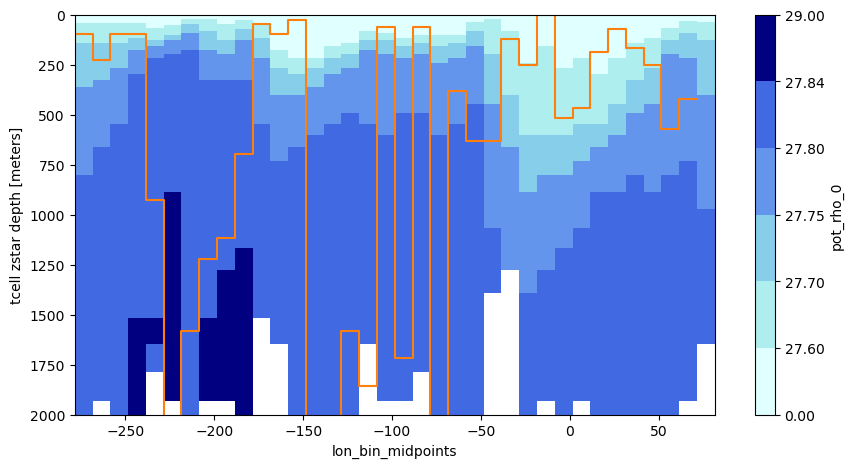

In [25]:
figure = plt.figure(num = 1, figsize = (10, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
potrho_transect_lonbin.plot.pcolormesh(levels=levels,colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy'])
plt.step(bin_edges[:-1],depth_rho, where='pre',color='tab:orange')
plt.ylim(2000,0)


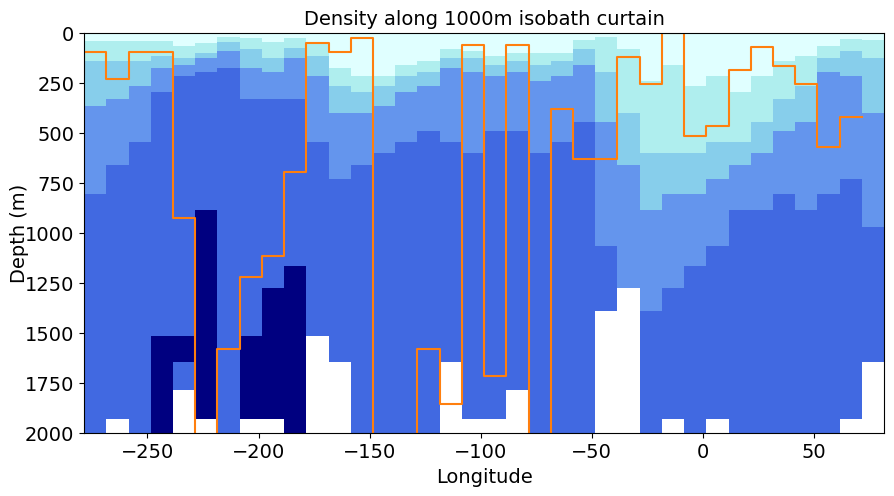

In [26]:
figure = plt.figure(num = 1, figsize = (10, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc = potrho_transect_lonbin.plot.pcolormesh(levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)


plt.ylim(2000,0)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize,labelpad=-3)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title('Density along 1000m isobath curtain',fontsize=fontsize)
plt.step(bin_edges[:-1],depth_rho, where='pre',color='tab:orange')


cax = fig.add_axes([.21,-.12,.6,.04])
cbar = plt.colorbar(pc, cax=cax,orientation='horizontal')
cbar.set_label(r'Density ($\sigma_0$)',fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)


This approach does not seem to be very good either...

- first, it does not allow the possibility of CDW waters flowing in below the maximum
- second, it has lots of twists and turns

So I think it might be useful to get age and temperature in density layers, and use that to define the CDW. CDW could then be the warmest + oldest water in each density bin, below 100m depth. that would allow CDW to be incoming or outgoing the contour as it should, and to move locations along time and space. I am not sure it would fix the problems with NaN's, but talking to Taimoor I had the impression that the correlations were done through linear regression, which would not take into account the NaNs anyways.... (Although it assumes a linear correlation)

# Age and temperature approach

In [27]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

#temperature
temp_transect = cc.querying.getvar(iaf_cycle3,'temp' , session,frequency='1 monthly',\
                                     chunks={'time':'200gb'}).isel(yt_ocean=slice(0,ylength)) - 273.15

temp_transect = temp_transect.stack(contour_index = ['yt_ocean', 'xt_ocean']).where(contour_mask_numbered_1d>0, drop = True)
temp_transect = temp_transect.sortby(contour_ordering)

#age
age_transect = cc.querying.getvar(iaf_cycle3,'age_global' , session,frequency='1 monthly',\
                                     chunks={'time':'200gb'}).isel(yt_ocean=slice(0,ylength))
age_transect = age_transect.stack(contour_index = ['yt_ocean', 'xt_ocean']).where(contour_mask_numbered_1d>0, drop = True)
age_transect = age_transect.sortby(contour_ordering)

#salt
salt_transect = cc.querying.getvar(iaf_cycle3,'salt' , session,frequency='1 monthly',\
                                     chunks={'time':'200gb'}).isel(yt_ocean=slice(0,ylength))

salt_transect = salt_transect.stack(contour_index = ['yt_ocean', 'xt_ocean']).where(contour_mask_numbered_1d>0, drop = True)
salt_transect = salt_transect.sortby(contour_ordering)

In [28]:
# %%time
# age_transect.load()
# temp_transect.load()
# salt_transect.load()

# #saving it
# age_transect['contour_index'] = CSHT_along.contour_index[:-1]
# age_transect.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/age_transect.nc')
# temp_transect['contour_index'] = CSHT_along.contour_index[:-1]
# temp_transect.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/temp_transect.nc')
# salt_transect['contour_index'] = CSHT_along.contour_index[:-1]
# salt_transect.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/salt_transect.nc')

In [29]:
#loading values along contour
age_transect = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/age_transect.nc')
temp_transect = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/temp_transect.nc')
salt_transect = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/salt_transect.nc')


In [30]:
#lets bin the data into the 10deg bins. and see how a TS diagram looks like in it

#binned salinity
salt_transect_bin=salt_transect.rename({'contour_index':'lon_along_contour'})
salt_transect_bin['lon_along_contour'] = CSHT_along.lon_along_contour.isel(time=0).drop('time')[:-1].values
salt_transect_bin = salt_transect_bin.groupby_bins('lon_along_contour',bins=bin_edges).mean()
salt_transect_bin = salt_transect_bin.rename({'lon_along_contour_bins':'lon_bin_midpoints'})


#binned temperature
temp_transect_bin=temp_transect.rename({'contour_index':'lon_along_contour'})
temp_transect_bin['lon_along_contour'] = CSHT_along.lon_along_contour.isel(time=0).drop('time')[:-1].values
temp_transect_bin = temp_transect_bin.groupby_bins('lon_along_contour',bins=bin_edges).mean()
temp_transect_bin = temp_transect_bin.rename({'lon_along_contour_bins':'lon_bin_midpoints'})

#binned age
age_transect_bin=age_transect.rename({'contour_index':'lon_along_contour'})
age_transect_bin['lon_along_contour'] = CSHT_along.lon_along_contour.isel(time=0).drop('time')[:-1].values
age_transect_bin = age_transect_bin.groupby_bins('lon_along_contour',bins=bin_edges).mean()
age_transect_bin = age_transect_bin.rename({'lon_along_contour_bins':'lon_bin_midpoints'})


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


In [31]:
salt_transect_bin = salt_transect_bin.salt
temp_transect_bin =     temp_transect_bin.temp
age_transect_bin = age_transect_bin.age_global

In [32]:
age_transect_bin_normalized = age_transect_bin/age_transect_bin.max('st_ocean')

In [33]:
#We need to normalized the age
age_transect_bin_normed = age_transect_bin/age_transect_bin.max(('st_ocean'))


#creating colormap
import matplotlib.colors as cl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
orange = np.array([248/256, 100/256, 0/256, 1])
newcolors[-52:, :] = orange #85 = -39: 80%  =52
newcmp = ListedColormap(newcolors)

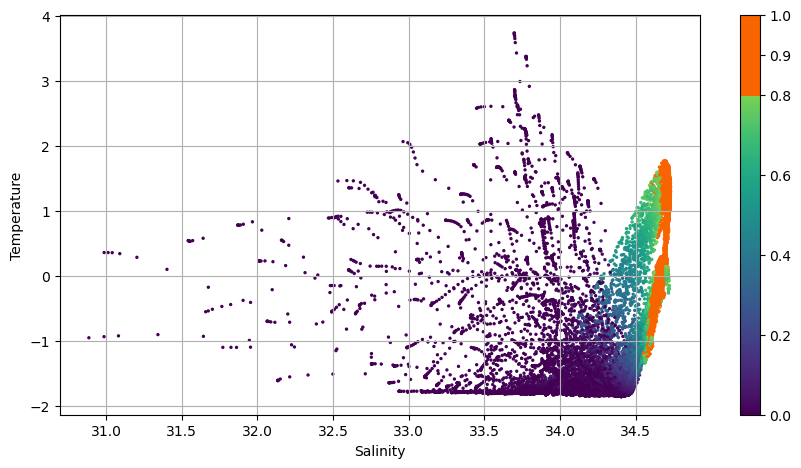

In [34]:
figure = plt.figure(num = 1, figsize = (10, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
nyear=40
time_ind=slice(12*nyear,(12*nyear)+12)
plt.scatter(salt_transect_bin.isel(time=time_ind)[:],\
            temp_transect_bin.isel(time=time_ind)[:],c=age_transect_bin_normalized.isel(time=time_ind)[:],\
            s=2,cmap=newcmp)
plt.colorbar(ticks=[0,.2,.4,.6,.8,.9,1])
plt.ylabel("Temperature"); plt.xlabel("Salinity")
plt.grid()

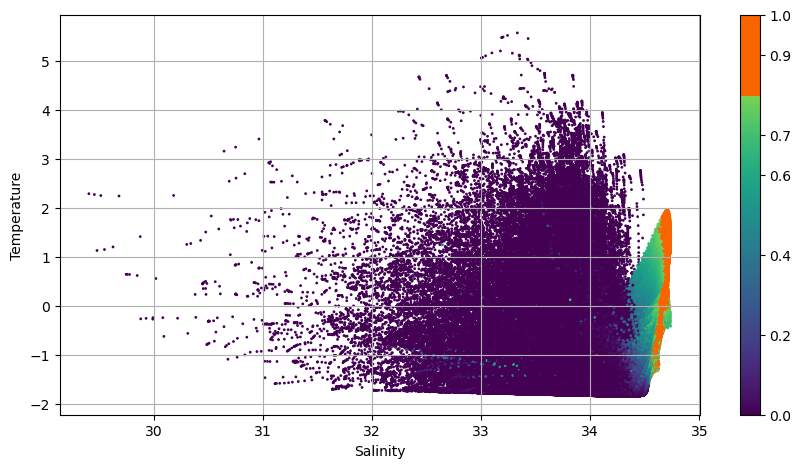

In [35]:
figure = plt.figure(num = 1, figsize = (10, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
plt.scatter(salt_transect_bin[:],\
            temp_transect_bin[:],c=age_transect_bin_normalized[:],\
            s=1,cmap=newcmp)
plt.colorbar(ticks=[0,.2,.4,.6,.7,.9,1])
plt.ylabel("Temperature"); plt.xlabel("Salinity")
plt.grid()

Text(0, 0.5, 'Latitude')

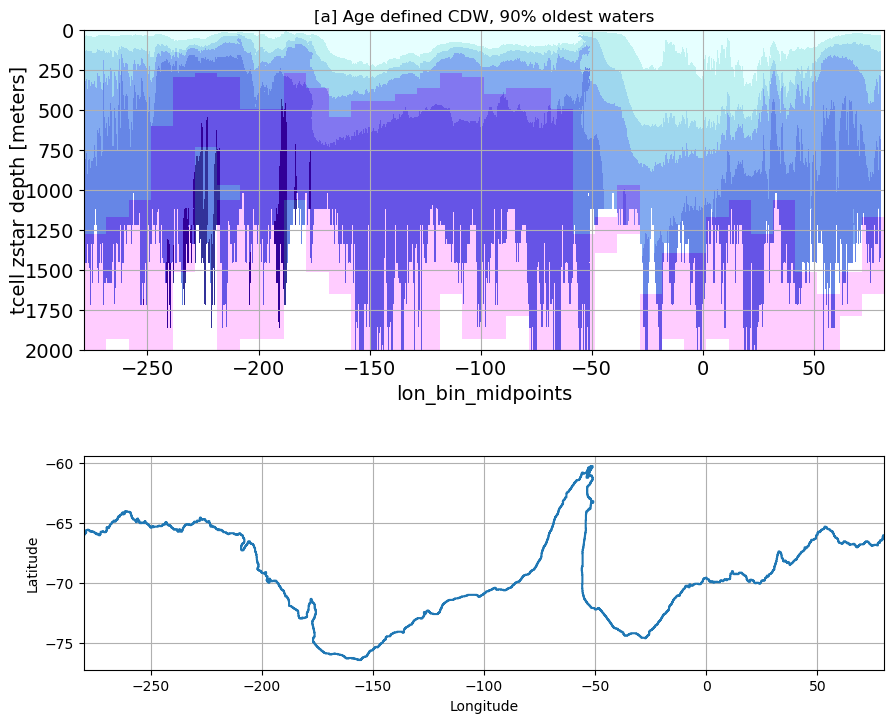

In [36]:
figure = plt.figure(num = 1, figsize = (10, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0)

plt.subplot(2,1,1)
norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc = plt.contourf(lon_along_contour, potrho_transect.st_ocean,\
                  potrho_transect-1000,levels=levels,\
                  colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue','navy'])

plt.tick_params(labelsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize,labelpad=-3)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title('Density along 1000m isobath curtain',fontsize=fontsize)
#plt.colorbar()

cax = fig.add_axes([.21,-.12,.6,.04])
cbar = plt.colorbar(pc, cax=cax,orientation='horizontal')
cbar.set_label(r'Density ($\sigma_0$)',fontsize=fontsize)
# cbar.ax.tick_params(labelsize=fontsize)
# age_transect_bin_normed.mean('time').plot.\
# contourf(x='lon_bin_midpoints',levels=[0,0.8,1],colors='none',hatches=['','.....'], add_colorbar=False)
age_transect_bin_normalized.mean('time').plot.\
pcolormesh(x='lon_bin_midpoints',levels=[0,0.90,1],colors=['white','magenta'],hatch=['','.....'],add_colorbar=False,alpha=0.2)
plt.grid('Minor')
plt.ylim(2000,0)
plt.title('[a] Age defined CDW, 90% oldest waters')

plt.subplot(3,1,3)
plt.plot(lon_along_contour,lat_along_contour)
plt.xlim(-280,80)
plt.grid('Minor')
plt.xlabel('Longitude'); plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

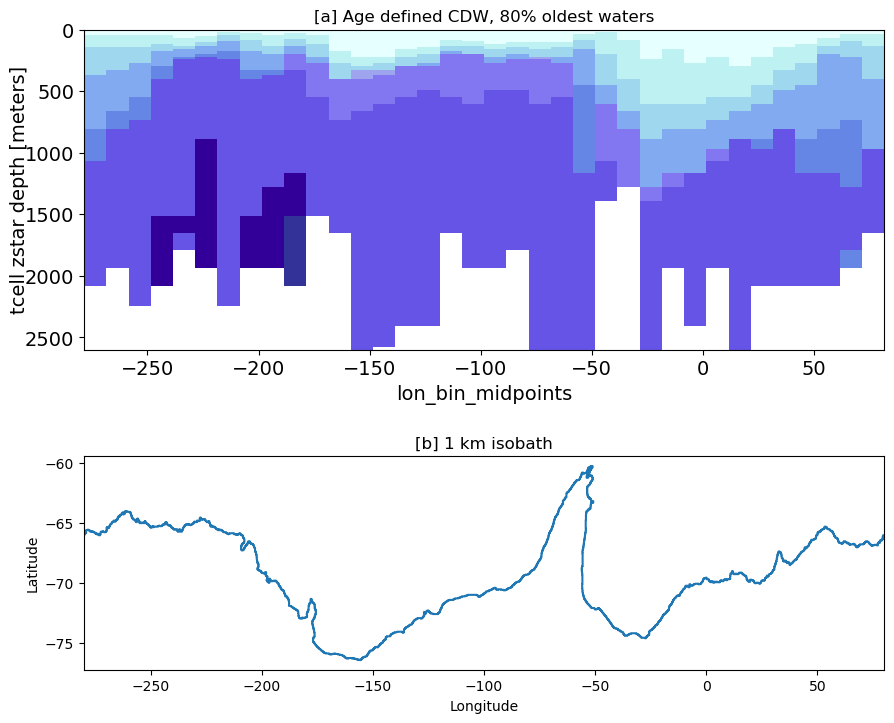

In [37]:
figure = plt.figure(num = 1, figsize = (10, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0)

plt.subplot(2,1,1)
norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

potrho_transect_lonbin.plot.pcolormesh(levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)


plt.tick_params(labelsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize,labelpad=-3)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title('Density along 1000m isobath curtain',fontsize=fontsize)


#cax = fig.add_axes([.21,-.12,.6,.04])
#cbar = plt.colorbar(pc, cax=cax,orientation='horizontal')
#cbar.set_label(r'Density ($\sigma_0$)',fontsize=fontsize)
#cbar.ax.tick_params(labelsize=fontsize)

age_transect_bin_normed.mean('time').plot.\
pcolormesh(x='lon_bin_midpoints',levels=[0,0.8,1],colors=['white','magenta'],hatch=['','.....'],add_colorbar=False,alpha=0.2)

plt.ylim(2600,0)
plt.title('[a] Age defined CDW, 80% oldest waters')


plt.subplot(3,1,3)
plt.plot(lon_along_contour,lat_along_contour)
plt.xlim(-280,80)
plt.title('[b] 1 km isobath')
plt.xlabel('Longitude'); plt.ylabel('Latitude')

90% oldest age seem to be a rather ok definition. The only issue migbt be that it covers a rather large portion of the water column in some regions, but mostly in the west of the Antarctic peninsula as it should

Above was a visualization of these tresholds in depth layers. 

Let's now transfer them to density layers.... s

in density layers the definition will become

CDW: age above normalized 0.9

DSW: waters below CDW

AASW: waters above CDW


**Converting definition to density layers**

How the direction of the heat transports change in each case?

In [38]:
from xhistogram.xarray import histogram

In [39]:
# # import monthly densities
# potrho_monthly = cc.querying.getvar(iaf_cycle3,'pot_rho_0' , session,frequency='1 monthly',chunks={'time':'400gb'}).isel(yt_ocean=slice(0,ylength))

# # first stack into 1d:
# potrho_monthly = potrho_monthly.stack(contour_index = ['yt_ocean', 'xt_ocean'])

# # # then select out only points on contour:
# potrho_monthly = potrho_monthly.where(contour_mask_numbered_1d>0, drop = True)


# # sort:
# potrho_monthly = potrho_monthly.sortby(contour_ordering)

In [40]:
# %%time
# potrho_monthly.load()
# #saving it
# potrho_monthly['contour_index'] = contour_ordering.values
# potrho_monthly.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/potrho_along_contour.nc')
potrho_monthly = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/potrho_along_contour.nc')

In [41]:
bin_edges
potrho_time = (potrho_monthly-1000)


#binned age
potrho_time_transect_bin=potrho_time.rename({'contour_index':'lon_along_contour'})
potrho_time_transect_bin['lon_along_contour'] = CSHT_along.lon_along_contour.isel(time=0).drop('time')[:-1].values
potrho_time_transect_bin = potrho_time_transect_bin.groupby_bins('lon_along_contour',bins=bin_edges).mean()
potrho_time_transect_bin = potrho_time_transect_bin.rename({'lon_along_contour_bins':'lon_bin_midpoints'})


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


In [42]:
%%time
#getting the surface area along the contour for averaging U data
tarea = cc.querying.getvar(iaf_cycle3,'area_t',session,n=1).isel(yt_ocean=slice(0,ylength))

# sort:
# first stack into 1d:
tarea_contour = tarea.stack(contour_index = ['yt_ocean', 'xt_ocean'])

# # then select out only points on contour:
tarea_contour = tarea_contour.where(contour_mask_numbered_1d>0, drop = True)
tarea_contour = tarea_contour.sortby(contour_ordering)
tarea_contour.load()


# #
# dzt = cc.querying.getvar(iaf_cycle3,'dzt',session,chunks={'time':'400gb'}).isel(yt_ocean=slice(0,ylength))
# # first stack into 1d:
# dzt_contour = dzt.stack(contour_index = ['yt_ocean', 'xt_ocean'])

# # # then select out only points on contour:
# dzt_contour = dzt_contour.where(contour_mask_numbered_1d>0, drop = True)


# # sort:
# dzt_contour = dzt_contour.sortby(contour_ordering)
# dzt_contour.compute()

# voL_contour = dzt_contour*tarea_contour


# #binned age
# vol_contour=voL_contour.rename({'contour_index':'lon_along_contour'})
# vol_contour['lon_along_contour'] = CSHT_along.lon_along_contour.isel(time=0).drop('time')[:-1].values
# vol_contour = vol_contour.groupby_bins('lon_along_contour',bins=bin_edges).sum()
# vol_contour = vol_contour.rename({'lon_along_contour_bins':'lon_bin_midpoints'})

# vol_contour.load()
# vol_contour.name = 'volume'
# vol_contour['lon_bin_midpoints'] = CSHT_along_10deg.lon_bins.values
# vol_contour.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/vol_along_contour.nc')

CPU times: user 1.12 s, sys: 218 ms, total: 1.34 s
Wall time: 1.34 s


<xarray.DataArray 'area_t' (contour_index: 6001)> Size: 24kB
array([21253122., 21253122., 21253122., ..., 21217946., 21217946.,
       21217946.], dtype=float32)
Coordinates:
  * contour_index  (contour_index) object 48kB MultiIndex
  * yt_ocean       (contour_index) float64 48kB -65.99 -65.99 ... -66.03 -66.03
  * xt_ocean       (contour_index) float64 48kB -279.9 -279.8 ... 79.85 79.95
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-11-11
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

In [43]:
vol_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/vol_along_contour.nc').volume

In [44]:
rho0_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
targetbins = np.append(np.append(1020,np.append(np.arange(1023,1027,.15),\
                                 np.linspace(1027,rho0_contour.pot_rho_0.max().values+0.2,80))),1030)-1000

In [45]:
vol_contour['lon_bin_midpoints'] = age_transect_bin_normalized.lon_bin_midpoints

In [46]:
#dinning age into sigma contours

age_sigma = histogram(potrho_time_transect_bin.pot_rho_0, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = age_transect_bin_normalized*vol_contour)/\
histogram(potrho_time_transect_bin.pot_rho_0, 
                          bins = targetbins, 
                          dim = ['st_ocean'],
                          weights = vol_contour)

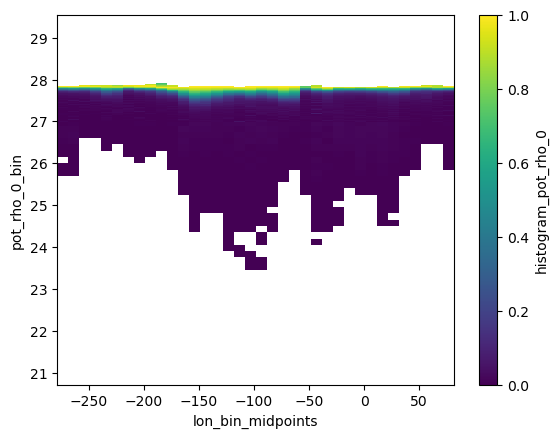

In [47]:
age_sigma.mean('time').plot(y='pot_rho_0_bin')

In [48]:
#cdw mask defined as any place where normalized ages are above 0.9
CDW_age_mask = (age_sigma.where(age_sigma>0.9)*0).rename({'lon_bin_midpoints':'lon_bins','pot_rho_0_bin':'potrho0'})+1

#Anything above the CDW will be classified as AASW
AASW_age_mask = (CDW_age_mask.bfill('potrho0') - CDW_age_mask.fillna(0))
AASW_age_mask = AASW_age_mask.where(AASW_age_mask>0)

#Anything below the CDW will be classified as DSW
DSW_age_mask = ((CDW_age_mask.fillna(0) + AASW_age_mask.fillna(0)))
DSW_age_mask =(DSW_age_mask.where(DSW_age_mask<1)*0)+1

(27.9, 27.2)

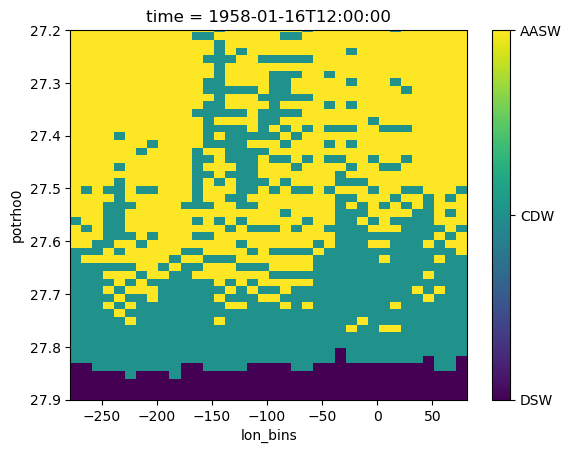

In [49]:
WMASES = (DSW_age_mask.fillna(0) + (CDW_age_mask.fillna(0)*2) + \
(AASW_age_mask.fillna(0)*3) ).isel(time=0).plot(y='potrho0',add_colorbar=False)
cbar = plt.colorbar(WMASES )
cbar.ax.set_yticks(ticks=[1,2,3])
cbar.ax.set_yticklabels(labels=['DSW','CDW','AASW'])
plt.ylim(27.9,27.2)

(27.9, 27.2)

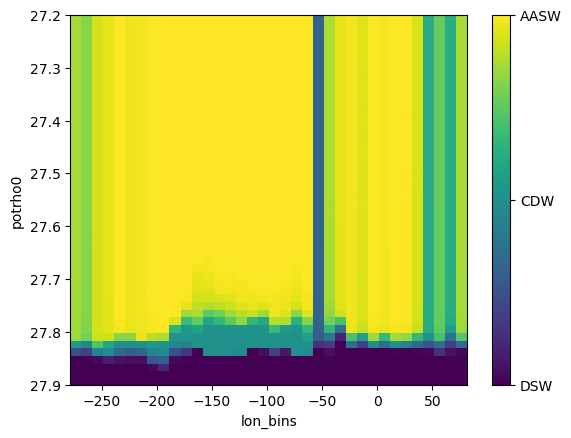

In [50]:
WMASES = (DSW_age_mask.fillna(0) + (CDW_age_mask.fillna(0)*2) + \
(AASW_age_mask.fillna(0)*3) ).mean('time').plot(y='potrho0',add_colorbar=False)
cbar = plt.colorbar(WMASES )
cbar.ax.set_yticks(ticks=[1,2,3])
cbar.ax.set_yticklabels(labels=['DSW','CDW','AASW'])
plt.ylim(27.9,27.2)

In [51]:
age_sigma['time']=CSHTZC_along_10deg.CSHT_ZC_lon_binned.resample(time='1M').mean().time
age_sigma['lon_bin_midpoints']=CSHTZC_along_10deg.lon_bins.values


CDW_CSHTZC_age  = CSHTZC_along_10deg.CSHT_ZC_lon_binned.resample(time='1M').mean()*CDW_age_mask
AASW_CSHTZC_age  = CSHTZC_along_10deg.CSHT_ZC_lon_binned.resample(time='1M').mean()*AASW_age_mask
DSW_CSHTZC_age  = CSHTZC_along_10deg.CSHT_ZC_lon_binned.resample(time='1M').mean()*DSW_age_mask

clustering_10deg = clustering_mask.fillna(0).groupby_bins('lon_bin_midpoints',bins=bin_edges).mean().round()
clustering_10deg = clustering_10deg.where(clustering_10deg>0).rename({'lon_bin_midpoints_bins':'lon_bins'})
clustering_10deg['lon_bins'] = CSHTZC_along_10deg.lon_bins.values


CDW_CSHTZC_age_regime = (CDW_CSHTZC_age.sum('potrho0').mean('time').cumsum() * clustering_10deg)
AASW_CSHTZC_age_regime = (AASW_CSHTZC_age.sum('potrho0').mean('time').cumsum() * clustering_10deg)
DSW_CSHTZC_age_regime = (DSW_CSHTZC_age.sum('potrho0').mean('time').cumsum() * clustering_10deg)

CDW_CSHTZC_age_regime.load()
AASW_CSHTZC_age_regime.load()
DSW_CSHTZC_age_regime.load()

print('Extracted CSHT in each water mass layer')



INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_

Extracted CSHT in each water mass layer


TypeError: No numeric data to plot.

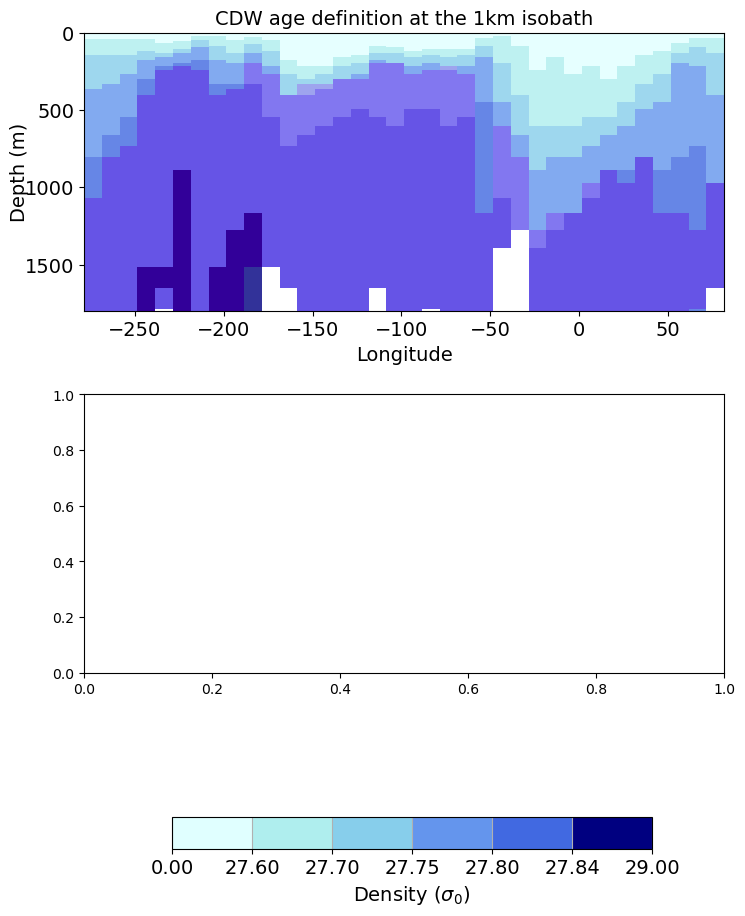

In [52]:
# do contourf with same levels as chosen density levels for CSHT analysis:
fontsize=14

fig = plt.figure(num = 1, figsize = (8, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)

plt.subplot(2,1,1) 

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc = potrho_transect_lonbin.plot.pcolormesh(levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)
age_transect_bin_normalized.mean('time').plot.\
pcolormesh(x='lon_bin_midpoints',levels=[0,0.80,1],colors=['white','magenta'],hatch=['','.....'],add_colorbar=False,alpha=0.2)

plt.ylim(1800,0)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize,labelpad=-3)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title('CDW age definition at the 1km isobath',fontsize=fontsize)

cax = fig.add_axes([.21,-.12,.6,.04])
cbar = plt.colorbar(pc, cax=cax,orientation='horizontal')
cbar.set_label(r'Density ($\sigma_0$)',fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.grid('Minor')


plt.subplot(2,1,2)
(CDW_CSHTZC_age_regime.isel(regime=1).cumsum()/1e12).plot(label=r'Variable $\sigma$',linewidth=.5,color='black')
(CSHT_ZC_perdensity.isel(potrho0=4).mean('time').isel(regime=0).cumsum()/1e12).plot(linestyle='--',label=r'fixed $27.8 <\sigma\ < 27.84$',linewidth=.5,color='black')
(CDW_CSHTZC_age_regime.isel(regime=0).cumsum()/1e12).plot(label='Surface',color='mediumseagreen')
(CDW_CSHTZC_age_regime.isel(regime=1).cumsum()/1e12).plot(label='Reverse',color='orangered')
(CDW_CSHTZC_age_regime.isel(regime=2).cumsum()/1e12).plot(label='Deep',color='blueviolet')
(CSHT_ZC_perdensity.isel(potrho0=4).mean('time').isel(regime=0).cumsum()/1e12).plot(linestyle='--',color='mediumseagreen')
(CSHT_ZC_perdensity.isel(potrho0=4).mean('time').isel(regime=1).cumsum()/1e12).plot(linestyle='--',color='orangered')
(CSHT_ZC_perdensity.isel(potrho0=4).mean('time').isel(regime=2).cumsum()/1e12).plot(linestyle='--',color='blueviolet')

plt.plot([-50,-50],[-30,30],linestyle=':',color='grey')
plt.plot([0,0],[-30,30],linestyle=':',color='grey')
plt.xlim(-280,80);plt.ylim(-30,5)
plt.title('Cumulative sum of time-mean heat transport')
plt.ylabel('TW')
plt.legend()

In [ ]:
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*2000*')

CSHTZC_z =( (CSHTZC_z.binned_cross_slope_heat_trans + CSHTZC_z.zonal_convergence)*0.08 ).resample(time='1M').mean().mean('time')

#binmin into 10deg
CSHTZC_z_10deg = CSHTZC_z.groupby_bins('lon_bin_midpoints',bins=bin_edges).sum().rename({'lon_bin_midpoints_bins':'lon_bins'})


In [ ]:
# do contourf with same levels as chosen density levels for CSHT analysis:
fontsize=14

fig = plt.figure(num = 1, figsize = (8, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.3)

plt.subplot(2,1,1) 

norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc = potrho_transect_lonbin.plot.pcolormesh(levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)
age_transect_bin_normalized.mean('time').plot.\
pcolormesh(x='lon_bin_midpoints',levels=[0,0.80,1],colors=['white','magenta'],hatch=['','.....'],add_colorbar=False,alpha=0.2)
plt.ylim(2000,0)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Depth (m)',fontsize=fontsize,labelpad=-3)
plt.xlabel('Longitude',fontsize=fontsize)
plt.title('CDW age definition at the 1km isobath',fontsize=fontsize)

cax = fig.add_axes([.21,-.12,.6,.04])
cbar = plt.colorbar(pc, cax=cax,orientation='horizontal')
cbar.set_label(r'Density ($\sigma_0$)',fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.grid('Minor')


plt.subplot(2,1,2)
CSHTZC_z_10deg.where(CSHTZC_z_10deg!=0).plot(x='lon_bins',vmin=-1,vmax=1,cmap='seismic',add_colorbar=False)
plt.ylim(2000,0)

In [ ]:
(CDW_CSHTZC_age_regime.sum('regime')/1e12).plot()

In [ ]:
(CDW_CSHTZC_age_regime.isel(regime=0).cumsum()/1e12).plot(color='mediumseagreen')
(CDW_CSHTZC_age_regime.isel(regime=1).cumsum()/1e12).plot(color='orangered')
(CDW_CSHTZC_age_regime.isel(regime=2).cumsum()/1e12).plot(color='blueviolet')

In [ ]:
(CSHT_ZC_perdensity.isel(potrho0=4).mean('time').sum('regime').cumsum()/1e12).plot(linestyle='--',label=r'fixed $27.8 <\sigma\ < 27.84$',linewidth=.5,color='black')


(CDW_CSHTZC_age_regime.sum('regime').cumsum()/1e12).plot()

(CDW_CSHTZC_age_regime.sum('regime')/(1e12*0.08)).plot()

In [ ]:
CSHT_ZC_CDW_mean_age = (CDW_CSHTZC_age_regime.sum('lon_bins'))
AASW_ZC_CDW_mean_age = (AASW_CSHTZC_age_regime.sum('lon_bins'))
DSW_ZC_CDW_mean_age = (DSW_CSHTZC_age_regime.sum('lon_bins'))


In [ ]:
#Bar plots with mean ASC speed, and CSHT values
plt.barh(np.arange(6,9),CSHT_ZC_AASW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet'],\
         label = ['Fresh','Warm','Dense']) #AASW
plt.barh(np.arange(3,6),CSHT_ZC_CDW_mean_age * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #CDW
plt.barh(np.arange(0,3),CSHT_ZC_DSW_mean * 1e-12,color=['mediumseagreen','orangered','blueviolet']) #DSW
plt.plot([-60,100],[2.5,2.5],linestyle='--',color='grey')
plt.plot([-60,100],[5.5,5.5],linestyle='--',color='grey')
plt.plot([0,0],[-1,10],color='black')
#plt.xlim([-60,65]);
plt.ylim([-1,9])
plt.legend(); plt.yticks([]);plt.xlabel(r'CSHT + ZC [$TW$]',fontsize=15)
plt.yticks(ticks=[1,4,7],labels=['DSW','CDW','AASW'],fontsize=16)

WHat is missing now:

-  define AASW as the layer above CDW

-  define DSW as the layer below it

- have a proper 10deg mask that does not overlap regimes

In [ ]:
DW